In [2]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from tqdm import tqdm
import pandas as pd
import os
import pickle

# loading environment variables from .env file
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
train_dataset = pd.read_csv("../data/hateXplain_clean_train.csv")
train_dataset['majority_vote'].value_counts()

majority_vote
normal         4748
hate speech    4383
Name: count, dtype: int64

In [5]:
test_dataset = pd.read_csv("../data/hateXplain_clean_test.csv")
test_dataset['majority_vote'].value_counts()

majority_vote
normal         594
hate speech    548
Name: count, dtype: int64

In [7]:
# As in the previous experiment, the test set will form the set of messages the LLM will evaluate
messages_to_evaluate = test_dataset
len(messages_to_evaluate)

1142

# Same helper functions as in the previous experiment

In [17]:

# Define the pydantic class with JSON schema for hate speech detection
class HateSpeechAnalysis(BaseModel):
    '''
    A pydantic class that specifies the json schema of the hate speech detection task
    '''
    classification: str = Field(
        ..., description="Classification of the message: 'normal' or 'hate speech'"
    )
    confidence: float = Field(
        ..., ge=0, le=100, description="Confidence score of the classification (0 to 100)"
    )
    reasoning: str = Field(..., description="Brief explanation for the classification")

    class Config:
        json_schema_extra = {
            "example": {
                "classification": "normal",
                "confidence": 95,
                "reasoning": "The message contains no offensive language or discriminatory content.",
            }
        }

# Initialize the ChatOpenAI model
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
)

In [18]:
# new prompt with the few shot examples placeholder

prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are an AI trained to detect hate speech."
        " Analyze given messages and determine if they are normal or hate speech."
        " Provide a classification, confidence score (0-100), and brief reasoning.",
    ),
    (
        "human",
        "Here are some examples of normal messages:\n\n{normal_few_shot_examples}\n\n"
        "Here are some examples of hate speech messages:\n\n{hate_few_shot_examples}\n\n"
        "Now, analyze the following message for hate speech: {message}",
    ),
])

# Create the chain with structured output
chain = prompt | llm.with_structured_output(HateSpeechAnalysis, include_raw=True)

# Sampling few shot examples from the training dataset

In [31]:
# for a better experiment design, the few shot examples will come from the train dataset
# will the messages that will be evaluated will come from the test set

In [9]:
# total number os few shot examples
n = 100
hate_examples = (
    train_dataset[train_dataset["majority_vote"] == "hate speech"][
        ["clean_message", "relevant_pieces"]
    ]
    .sample(n // 2, random_state=42)
    .reset_index(drop=True)
)
normal_examples = (
    train_dataset[train_dataset["majority_vote"] == "normal"][
        ["clean_message", "relevant_pieces"]
    ]
    .sample(n // 2, random_state=42)
    .reset_index(drop=True)
)


In [12]:
# formatting the few shot examples
normal_few_shot_examples = "\n\n".join([f"{i+1}\n\tmessage: {row["clean_message"]}\n\tlabel: normal" for i, row in normal_examples.iterrows()])
hate_few_shot_examples = "\n\n".join([f"{i+1}\n\tmessage: {row["clean_message"]}\n\tlabel: hate speech" for i, row in hate_examples.iterrows()])

In [13]:
print(normal_few_shot_examples)

1
	message: what i am willing to recognize is that people willingly follow a raghead rapist and think they are doing something moral
	label: normal

2
	message: white boys and ghetto white girls make me sick i can not stand you all
	label: normal

3
	message: imagine being a lying kike shill like
	label: normal

4
	message: continues to brag about muting continues to prove my point about him being a kike continues to do the kike thing of projecting mental deficiencies
	label: normal

5
	message: this is fucking bullshit the sand niggers got told they were being sent back so they rioted they were not protesting conditions daily mail is horse shit
	label: normal

6
	message: listen lady kill yourself
	label: normal

7
	message: following on from the other socialist tory pm the equally useless europhile traitor camoron theresa sharia may decides to try the hug a moslem suicide bomber approach
	label: normal

8
	message: i tolled this nigger to tears
	label: normal

9
	message: he a midget

In [14]:
print(hate_few_shot_examples)

1
	message: they must be a big minority in d.c. seeing  voted for the devil bitch 😈
	label: hate speech

2
	message: i hate you black bastards
	label: hate speech

3
	message: they need to have their own movement separated from lesbian and gay movements cuz they ’ re really not the same
	label: hate speech

4
	message: my niggas do not want no smoke in that bowling tonight them hoes scared they know ima win 🤣 🎳
	label: hate speech

5
	message: the singularity already happened retard where do you think you even came from
	label: hate speech

6
	message: i am starting to think trump is our hitler and if you actually know what i mean when i say that you are smart if you think im saying he literally hitler you are retarded and cant make out what i am saying
	label: hate speech

7
	message: he looks evil and she just looks retarded
	label: hate speech

8
	message: dear laowai asians are model citizens see
	label: hate speech

9
	message: this nigga austin smoke w his little work faggots eve

In [20]:
# testing the chain
chain.invoke({"normal_few_shot_examples": normal_few_shot_examples, 
              "hate_few_shot_examples": hate_few_shot_examples,
              "message": messages_to_evaluate['clean_message'][0]
            })

{'raw': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_333PvI7Rw5J5nIITMIJAIVif', 'function': {'arguments': '{"classification":"hate speech","confidence":85,"reasoning":"The message uses the term \'retarded\' in a derogatory manner, which is considered hate speech as it targets individuals with intellectual disabilities in a negative way."}', 'name': 'HateSpeechAnalysis'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 3660, 'total_tokens': 3706, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_1bb46167f9', 'finish_reason': 'stop', 'logprobs': None}, id='run-12ef2977-8f42-44f7-a7e9-1365348b85ce-0', tool_calls=[{'name': 'HateSpeechAnalysis', 'args': {'classification': 'hate speech', 'confidence': 85, 'reasoning': "The message uses the term 'retarded' in a derogatory manner, which is considered hate speech as it targets indivi

# Running the LLM chain with the whole dataset

In [22]:
# preprocessing the inputs
input_data = [
    {
        "normal_few_shot_examples": normal_few_shot_examples,
        "hate_few_shot_examples": hate_few_shot_examples,
        "message": msg
    }
    for msg in messages_to_evaluate["clean_message"]
]

classification_results = [None] * len(input_data) # list that will store the classification results
bad_idx_lst = [] # list of index that couldn´t be processed
for idx, input in tqdm(enumerate(input_data), total=len(input_data)):
    try:
        classification_results[idx] = chain.invoke(input)
    except:
        print(
            f"problem processing message with index {idx}. Adding a placeholder to the classification results"
        )
        bad_idx_lst.append(idx)


100%|██████████| 1142/1142 [30:06<00:00,  1.58s/it]


### Parsing classification results

In [23]:
classification_results[0]

{'raw': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_W3ZVXrteO5JFwS5pX516RDPq', 'function': {'arguments': '{"classification":"hate speech","confidence":85,"reasoning":"The message uses the term \'retarded\' in a derogatory manner, which is often associated with hate speech against individuals with intellectual disabilities. This language can perpetuate stigma and discrimination."}', 'name': 'HateSpeechAnalysis'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 3660, 'total_tokens': 3711, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_1bb46167f9', 'finish_reason': 'stop', 'logprobs': None}, id='run-fc4b0ddc-f0b7-481b-bf26-f1b5f0a72043-0', tool_calls=[{'name': 'HateSpeechAnalysis', 'args': {'classification': 'hate speech', 'confidence': 85, 'reasoning': "The message uses the term 'retarded' in a derogatory manner, which is 

In [25]:
# Creating the columns
messages_to_evaluate['classification'] = ''
messages_to_evaluate["confidence"] = ""
messages_to_evaluate["reasoning"] = ""

# populating the columns
for idx in range(len(messages_to_evaluate)):
    messages_to_evaluate.loc[idx, "classification"] = classification_results[idx][
        "parsed"
    ].classification
    messages_to_evaluate.loc[idx, "confidence"] = classification_results[idx][
        "parsed"
    ].confidence
    messages_to_evaluate.loc[idx, "reasoning"] = classification_results[idx][
        "parsed"
    ].reasoning

In [26]:
messages_to_evaluate.head()

,id,clean_message,majority_vote,relevant_pieces,classification,confidence,reasoning
0,1252707503441313794_twitter,why are you repeating yourself are you a littl...,hate speech,retarded,hate speech,85.0,The message uses the term 'retarded' in a dero...
1,1103385226921762816_twitter,well she ’ muslim so of course she hates the j...,normal,muslim she hates the jews jew hatred islam,hate speech,95.0,The message expresses a generalization about M...
2,1169443635869487105_twitter,lol not me i don ’ t deal with bms not outside...,hate speech,ghetto,hate speech,85.0,The message uses derogatory language ('ghetto ...
3,17372469_gab,an these nigger biches look like godzilla nasty,normal,nigger,hate speech,95.0,The message contains a racial slur ('nigger') ...
4,1168407844095483904_twitter,yeah humnh what how do i use this app i ’ m al...,hate speech,retarded,hate speech,85.0,The use of the term 'retarded' is derogatory a...


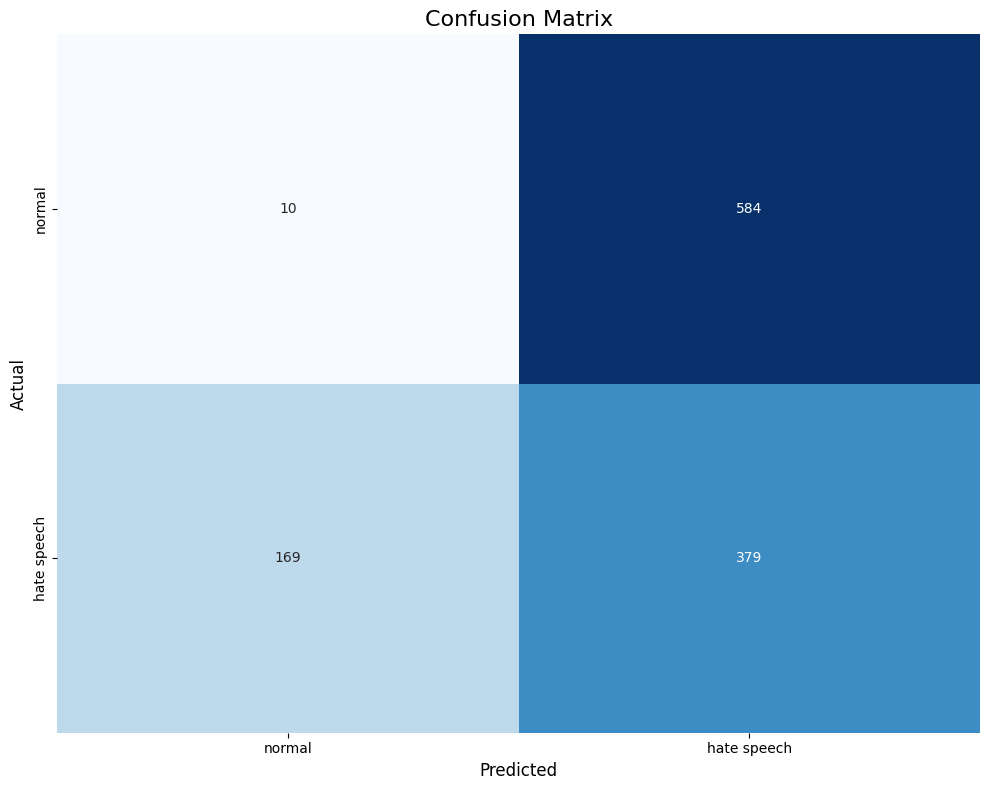

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

label_to_int = {'normal': 0, 'hate speech': 1}
y_true = messages_to_evaluate["majority_vote"].map(label_to_int)
y_pred = messages_to_evaluate["classification"].map(label_to_int)
# Create the confusion matrix

cm = confusion_matrix(y_true, y_pred)

# Create labels for the classes 
class_names = ["normal", "hate speech"] 

# Create a figure and axis
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=False
)

# Set title and labels
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [28]:
from sklearn.metrics import classification_report, roc_auc_score, roc_auc_score
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.06      0.02      0.03       594
           1       0.39      0.69      0.50       548

    accuracy                           0.34      1142
   macro avg       0.22      0.35      0.26      1142
weighted avg       0.22      0.34      0.25      1142



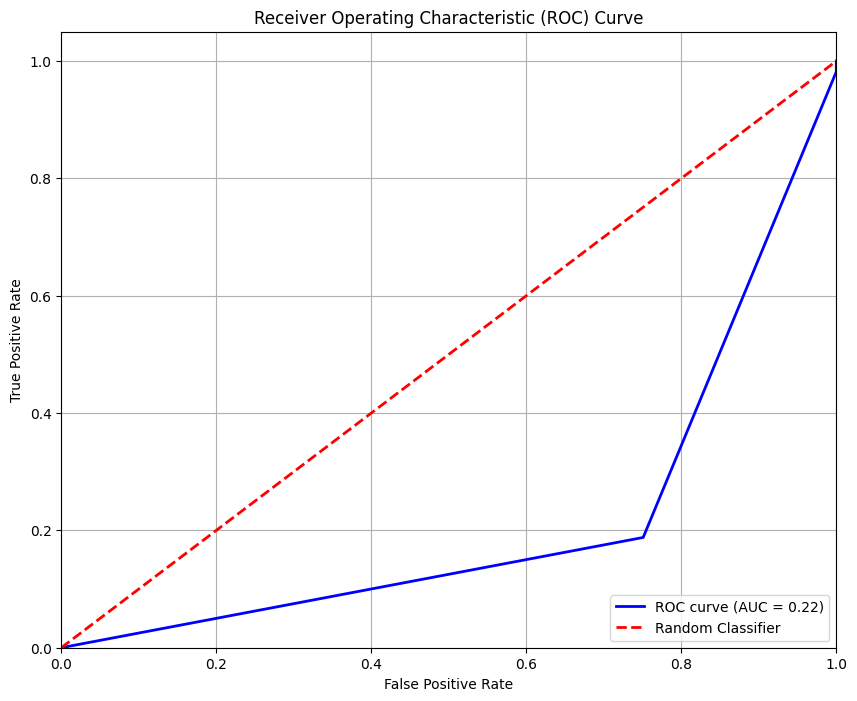

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get the predicted probabilities
y_scores = messages_to_evaluate["confidence"]

fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_true, y_scores)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--", label="Random Classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)

# Show the plot
plt.show()


In [30]:
messages_to_evaluate.Cusito_csv('../data/final_dataset_exp2.csv', index=False)